# Customer Behavior Prediction using Deep Learning

Author: Tatsiana Mihai

## Project description

For this project I'll use public datasets with user behavior information available on Kaggle:
- Model training: E-commerce behavior data from multi category store for November 2019
https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
- Validating model robustness: E-commerce behavior data from multi category store for January 2020 https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store


## Data exploration

In [4]:
# import required packages

import pandas as pd
import numpy as np

In [5]:
# read csv file and get the number of rows

df = pd.read_csv('data/2020-Jan.csv')
df.count()

event_time       55967041
event_type       55967041
product_id       55967041
category_id      55967041
category_code    50922151
brand            49426786
price            55967041
user_id          55967041
user_session     55967022
dtype: int64

In [ ]:
# show the first rows in the dataframe
df.head()

Let's check the quality of the data. Firts, I want to make sure there're no rows with null or invalid values that might affect model training. 
Let's check which columns have null values and how many.

In [ ]:
# show sum of null values for each column

df.isnull().sum()

As we can see, there're quite many missed values for `category_code` and `brand`, and also 10 missed values for the `user_session`. 
Now let's check if there're negative `price` values for as they're invalid and will affect the accuracy of the trained model.

In [ ]:
# show sum of negative values for the column `price`

(df.price < 0).sum()

As we can see, all prices are greater than `0` which makes the dataset is pretty clean. The only issue I'd like to address is the missed values. Also, I'd like to transform composite values in the `category_column` into multi-dimentional features to later try different combinations for model training.

## Data preprocessing

**Reduce dimensionality**  
The dataset is large, however not all of the columns are signficant for model training. The `user_session` column can be dropped as the `user_id` colimn contains all necessary information without missed values. Therefore, I'll remove `user_id` from the dataset.

In [3]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'category_code',
    'product_id',
    'category_id',
    'brand',
    'price',
    'user_id'
]

df = df[required_cols]
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id
0,2020-01-01 00:00:00 UTC,view,construction.tools.light,1005073,2232732093077520756,samsung,1130.02,519698804
1,2020-01-01 00:00:01 UTC,view,construction.tools.light,1005192,2232732093077520756,meizu,205.67,527767423
2,2020-01-01 00:00:01 UTC,view,apparel.shirt,100063693,2053013552427434207,turtle,136.43,519046195
3,2020-01-01 00:00:01 UTC,view,apparel.shoes,5100816,2232732103831716449,xiaomi,29.95,518269232
4,2020-01-01 00:00:02 UTC,view,apparel.shoes.step_ins,100014325,2232732103294845523,intel,167.20,587748686


**Handling the missing values**

As we can see from the data exploration, there're 9224078 missed values in the `brand` column. As there's still other information such as `event_type`, `user_id` and `price`, which can be useful for ML training, I'll fill it with the value `unknown`. 
Apart fron that, some of `category_code` values contain `NaN` instead of expected string values which causes issues with data transformation. I'll fill them with `unknown` values as well.

In [4]:
df['brand'] = df['brand'].fillna('unknown')
df['category_code'] = df['category_code'].fillna('unknown')
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id
0,2020-01-01 00:00:00 UTC,view,construction.tools.light,1005073,2232732093077520756,samsung,1130.02,519698804
1,2020-01-01 00:00:01 UTC,view,construction.tools.light,1005192,2232732093077520756,meizu,205.67,527767423
2,2020-01-01 00:00:01 UTC,view,apparel.shirt,100063693,2053013552427434207,turtle,136.43,519046195
3,2020-01-01 00:00:01 UTC,view,apparel.shoes,5100816,2232732103831716449,xiaomi,29.95,518269232
4,2020-01-01 00:00:02 UTC,view,apparel.shoes.step_ins,100014325,2232732103294845523,intel,167.20,587748686


Let's see how many categories we can restore by mapping their known brands. To do that, I'll get a list of unique combinations of unknown category codes and known brands. 

In [5]:
# extract uniquecvalues from `category_code` and `brand` columns

unknown_cats = df[(df.category_code == 'unknown') & (df.brand != 'unknown')]
unknown_cats = pd.unique(unknown_cats['brand'])

len(unknown_cats)

1868

Now let's explore if it's possible to re-use category that defined for another product with the same `brand` value. To do that I'll fetch all categories from `category_code` for the brands listed in the `unknown_cats`

<Axes: xlabel='category_code'>

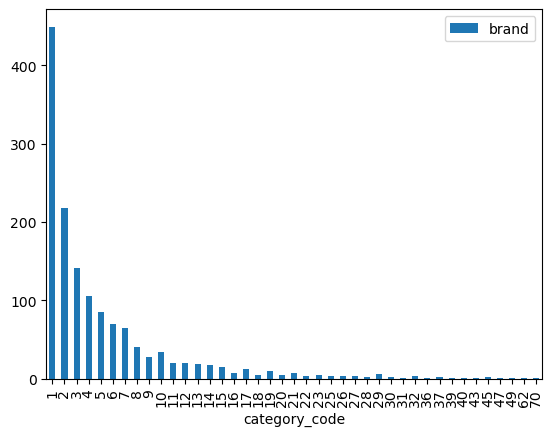

In [6]:
# try to find categories for the brands

known_brands = df[(df.category_code != 'unknown') & (df.brand.isin(unknown_cats))]
known_brands = known_brands[['category_code', 'brand']]
brands_possible_cats = known_brands.groupby(by=['brand']).nunique().reset_index()

# group brands to see how many potential categories each brand has
grouped_known_brands = brands_possible_cats.groupby(by=['category_code']).count()
grouped_known_brands.plot(kind='bar')

As the plot shows, a big chunk of brands has just one possible category. Let's explore some of them

In [7]:
brands_with_single_cat = brands_possible_cats[\
        brands_possible_cats.category_code == 1].brand

known_brands[known_brands.brand.isin(brands_with_single_cat)][210:220]

,category_code,brand
41838,sport.trainer,jiaxingharleybabycar
41843,furniture.living_room.sofa,rals
41947,sport.trainer,jiaxingharleybabycar
42079,sport.trainer,jiaxingharleybabycar
42084,sport.trainer,jiaxingharleybabycar
42168,sport.trainer,jiaxingharleybabycar
42180,furniture.living_room.sofa,rals
42203,kids.toys,edufun
42519,furniture.living_room.sofa,rals
42826,furniture.living_room.sofa,rals


In [ ]:
brands_with_multi_cat = brands_possible_cats[\
        brands_possible_cats.category_code > 25].brand

known_brands[known_brands.brand.isin(brands_with_multi_cat)].head()

In [ ]:
known_brands[known_brands.brand == 'xiaomi'].head(20)

At this moment it's obviout that only the first level category makes sence to be copied and added to the rows with missed values. If I add second or third category level I might affect the quality of the data.

**Data transformation**  
First, I want to transform values from `category_code` into multi-column data `cat_1`, `cat_2`, etc.
To make it I need to know the length of the longest chain in the `category_code` column.

In [ ]:
# calculate the max number of categories

max(df.category_code.transform(lambda x: x.str.split('.').transform(lambda y: len(y))))

**Imputation**
The maximum length of nested categories is `4`. Now it's possible to create new columns to store each category separately. As only the first layer of categories is to be filled for unknown categories, the other empty values can be filled with `unknown`.  

In [8]:
# split `category_code` column into new columns
df[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = df.category_code.str.split(".", expand = True)
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id,cat_1,cat_2,cat_3,cat_4
0,2020-01-01 00:00:00 UTC,view,construction.tools.light,1005073,2232732093077520756,samsung,1130.02,519698804,construction,tools,light,None
1,2020-01-01 00:00:01 UTC,view,construction.tools.light,1005192,2232732093077520756,meizu,205.67,527767423,construction,tools,light,None
2,2020-01-01 00:00:01 UTC,view,apparel.shirt,100063693,2053013552427434207,turtle,136.43,519046195,apparel,shirt,None,None
3,2020-01-01 00:00:01 UTC,view,apparel.shoes,5100816,2232732103831716449,xiaomi,29.95,518269232,apparel,shoes,None,None
4,2020-01-01 00:00:02 UTC,view,apparel.shoes.step_ins,100014325,2232732103294845523,intel,167.20,587748686,apparel,shoes,step_ins,None


As the values from the `category_code` column are transferred to another columns, it can be finally removed.

In [9]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'product_id',
    'category_id',
    'cat_1',
    'cat_2',
    'cat_3',
    'cat_4',
    'brand',
    'price',
    'user_id'
]

df = df[required_cols]
df.head()

,event_time,event_type,product_id,category_id,cat_1,cat_2,cat_3,cat_4,brand,price,user_id
0,2020-01-01 00:00:00 UTC,view,1005073,2232732093077520756,construction,tools,light,None,samsung,1130.02,519698804
1,2020-01-01 00:00:01 UTC,view,1005192,2232732093077520756,construction,tools,light,None,meizu,205.67,527767423
2,2020-01-01 00:00:01 UTC,view,100063693,2053013552427434207,apparel,shirt,None,None,turtle,136.43,519046195
3,2020-01-01 00:00:01 UTC,view,5100816,2232732103831716449,apparel,shoes,None,None,xiaomi,29.95,518269232
4,2020-01-01 00:00:02 UTC,view,100014325,2232732103294845523,apparel,shoes,step_ins,None,intel,167.20,587748686


Let's see how many new null varues have been created after changing the dimension of the data.

In [ ]:
# show sum of null values for each column

df.isnull().sum()

The `cat_1` doesn't have empty values as it's been pre-filled with `unknown`. For the others the % of filling is 99.9% for the `cat_2`, 72.1% for the `cat_3`, and 32.4% for the `cat_4`. Though the last column doesn't look promising I'll keep it for know to be able to use it in future training and see how it affects the model.
Let's fill the `unknown` values in `cat_1` with the values from known brands. To make it easier I change `known_brands` in the same way I changed the dataset.

In [10]:
# split `category_code` column into new columns
known_brands[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = known_brands.category_code.str.split(".", expand = True)
known_brands = known_brands[['brand', 'cat_1']].drop_duplicates(subset=['brand'])
known_brands.head()

,brand,cat_1
0,samsung,construction
3,xiaomi,apparel
7,sven,appliances
9,apple,construction
10,braun,appliances


In [11]:
res = pd.merge(df, known_brands, on='brand', how='left')
res.head()

,event_time,event_type,product_id,category_id,cat_1_x,cat_2,cat_3,cat_4,brand,price,user_id,cat_1_y
0,2020-01-01 00:00:00 UTC,view,1005073,2232732093077520756,construction,tools,light,None,samsung,1130.02,519698804,construction
1,2020-01-01 00:00:01 UTC,view,1005192,2232732093077520756,construction,tools,light,None,meizu,205.67,527767423,NaN
2,2020-01-01 00:00:01 UTC,view,100063693,2053013552427434207,apparel,shirt,None,None,turtle,136.43,519046195,NaN
3,2020-01-01 00:00:01 UTC,view,5100816,2232732103831716449,apparel,shoes,None,None,xiaomi,29.95,518269232,apparel
4,2020-01-01 00:00:02 UTC,view,100014325,2232732103294845523,apparel,shoes,step_ins,None,intel,167.20,587748686,NaN


In [12]:
res['cat'] = np.where(res['cat_1_x'] == 'unknown', res.cat_1_y, res.cat_1_x)
res.head()

,event_time,event_type,product_id,category_id,cat_1_x,cat_2,cat_3,cat_4,brand,price,user_id,cat_1_y,cat
0,2020-01-01 00:00:00 UTC,view,1005073,2232732093077520756,construction,tools,light,None,samsung,1130.02,519698804,construction,construction
1,2020-01-01 00:00:01 UTC,view,1005192,2232732093077520756,construction,tools,light,None,meizu,205.67,527767423,NaN,construction
2,2020-01-01 00:00:01 UTC,view,100063693,2053013552427434207,apparel,shirt,None,None,turtle,136.43,519046195,NaN,apparel
3,2020-01-01 00:00:01 UTC,view,5100816,2232732103831716449,apparel,shoes,None,None,xiaomi,29.95,518269232,apparel,apparel
4,2020-01-01 00:00:02 UTC,view,100014325,2232732103294845523,apparel,shoes,step_ins,None,intel,167.20,587748686,NaN,apparel


In [13]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'product_id',
    'category_id',
    'cat',
    'cat_2',
    'cat_3',
    'cat_4',
    'brand',
    'price',
    'user_id'
]

res = res[required_cols]
res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,2020-01-01 00:00:00 UTC,view,1005073,2232732093077520756,construction,tools,light,None,samsung,1130.02,519698804
1,2020-01-01 00:00:01 UTC,view,1005192,2232732093077520756,construction,tools,light,None,meizu,205.67,527767423
2,2020-01-01 00:00:01 UTC,view,100063693,2053013552427434207,apparel,shirt,None,None,turtle,136.43,519046195
3,2020-01-01 00:00:01 UTC,view,5100816,2232732103831716449,apparel,shoes,None,None,xiaomi,29.95,518269232
4,2020-01-01 00:00:02 UTC,view,100014325,2232732103294845523,apparel,shoes,step_ins,None,intel,167.20,587748686


In [ ]:
res.isnull().sum()

In [14]:
res['cat'] = res['cat'].fillna('unknown')
res['cat_2'] = res['cat_2'].fillna('unknown')
res['cat_3'] = res['cat_3'].fillna('unknown')
res['cat_4'] = res['cat_4'].fillna('unknown')
res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,2020-01-01 00:00:00 UTC,view,1005073,2232732093077520756,construction,tools,light,unknown,samsung,1130.02,519698804
1,2020-01-01 00:00:01 UTC,view,1005192,2232732093077520756,construction,tools,light,unknown,meizu,205.67,527767423
2,2020-01-01 00:00:01 UTC,view,100063693,2053013552427434207,apparel,shirt,unknown,unknown,turtle,136.43,519046195
3,2020-01-01 00:00:01 UTC,view,5100816,2232732103831716449,apparel,shoes,unknown,unknown,xiaomi,29.95,518269232
4,2020-01-01 00:00:02 UTC,view,100014325,2232732103294845523,apparel,shoes,step_ins,unknown,intel,167.20,587748686


#### ML specific preprocessing

Data that is used for training model must be numeric. However, the dataset contains a few columns `string` or `datetime` types. First, let's convert `datetime` in the `event_time` into a `timetuple`

In [6]:
# import required packages
import time
import datetime

res.event_time = res.event_time.apply(lambda x: time.mktime(datetime.datetime.strptime(x,
                                             "%Y-%m-%d %H:%M:%S %Z").timetuple()))

NameError: name 'res' is not defined

The other columns can be converted to numeric values by using label encoding. I'll use the `LabelEncoder` class that Scikit-learn provides for this purpose.

In [16]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
categorical_columns = [
    'event_type', 
    'cat', 
    'cat_2', 
    'cat_3', 
    'cat_4', 
    'brand'
]

for col in categorical_columns:
    res[col] = label_encoder.fit_transform(res[col])


In [18]:
# Normalize/Standardize numerical columns
scaler = StandardScaler()
res['price'] = scaler.fit_transform(res['price'].values.reshape(-1, 1))
res['event_time'] = scaler.fit_transform(res['event_time'].values.reshape(-1, 1))

In [ ]:
res.head()

The dataframe is ready for using in model training. I'll save it to a new .csv file to use it later for training.

In [19]:
# saving in a file
res.to_csv('data/processed_data_test.csv')

I repeat the same oreration for Jan and save it in 'data/processed_data_test.csv'

## Model training

In [ ]:
# uncomment lines below if tensorflow isn't installed on your PC

# import sys
# !{sys.executable} -m pip install tensorflow


### CNN

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score

In [2]:
# Load the dataset
train_data = pd.read_csv('data/processed_data_train.csv')

In [3]:
# Normalize price
train_data['price'] = (train_data['price'] - train_data['price'].mean()) / train_data['price'].std()

In [4]:
# Sort data by 'event_time' 
train_data.sort_values(by='event_time', inplace=True)

In [6]:
# Split the data into training and testing sets
X = train_data[['product_id', 'category_id', 'cat', 'cat_2', 'cat_3', 'cat_4', 'brand', 'price']]
y = train_data['event_type']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [32]:
# len(X)
def sequence_generator(X, y, sequence_length, batch_size):
    while True:
        for i in range(0, len(X) - sequence_length, batch_size):
            X_batch = [X[i+j:i+j+sequence_length].values for j in range(batch_size)]
            y_batch = y[i+sequence_length:i+sequence_length+batch_size]

            # Pad sequences to ensure they have the same length
            max_length = max(len(seq) for seq in X_batch)
            X_batch = [np.pad(seq, (0, max_length - len(seq)), 'constant') for seq in X_batch]

            yield np.array(X_batch), np.array(y_batch)

In [33]:
# Create sequences from the data
sequence_length = 1000 
batch_size = 256
train_data_generator = sequence_generator(X_train, y_train, sequence_length, batch_size)
test_data_generator = sequence_generator(X_test, y_test, sequence_length, batch_size)

In [34]:
# Define the CNN model
input_layer = Input(shape=(sequence_length, X_train.shape[1]))
x = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)  

In [35]:
from tensorflow.keras.optimizers.legacy import Adam

# Initialize the optimizer with gradient clipping
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model using the generator
model.fit(train_data_generator, 
          epochs=10, 
          steps_per_epoch=len(X_train) // batch_size,
          validation_data=test_data_generator,          # Validation data generator
          validation_steps=len(X_test) // batch_size,   # Number of validation steps
          verbose=1              # Verbosity mode (0: silent, 1: progress bar, 2: one line per epoch
         )

Epoch 1/10
 71205/210943 [=========>....................] - ETA: 3:58:20 - loss: -453965510133286960380516499456.0000 - accuracy: 0.0136

#### Second attempt - multiple improvements

In [ ]:
# Create sequences from the data
sequence_length = 100 
batch_size = 64
train_data_generator = sequence_generator(X_train, y_train, sequence_length, batch_size)
test_data_generator = sequence_generator(X_test, y_test, sequence_length, batch_size)

In [ ]:
# Define the CNN model
input_layer = Input(shape=(sequence_length, X_train.shape[1]))
x = Conv1D(128, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=3)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) 
output_layer = Dense(3, activation='sigmoid')(x)  

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.9)

# Use the learning rate schedule in the optimizer
optimizer = Adam(learning_rate=lr_schedule)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the generator
model.fit(train_data_generator, epochs=100, steps_per_epoch=len(X_train)//batch_size, 
         validation_data=test_data_generator, validation_steps=len(X_test)//batch_size,
         callbacks=[early_stopping])

### RNN

In [ ]:
import numpy as np
import pandas as pd



In [ ]:
# load the preprocessed dataset 
data = pd.read_csv('processed_data.csv')

In [ ]:
# Define your RNN architecture
rnn_model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(N, X.shape[0])),
    Dropout(0.2),
    LSTM(units=64),
    Dropout(0.2),
    Dense(9, activation='softmax')
])

In [ ]:
# Compile the model with F1 score metric
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

#### Second attempt - multiple improvements

## Model evaluation

### Baseline comparison

In [8]:
import pandas as pd

# import packages required for decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# load the preprocessed datasets 
train_data = pd.read_csv('data/processed_data_train.csv')
test_data = pd.read_csv('data/processed_data_test.csv')

In [9]:
# separate features (X) and target (y)
Train_X = train_data.drop('event_type', axis=1)
Train_y = train_data['event_type']

Test_X = test_data.drop('event_type', axis=1)
Test_y = test_data['event_type']

# split the data into training and testing sets 80/20
Train_X_train, Train_X_test, Train_y_train, Train_y_test = train_test_split(Train_X,
                                                                            Train_y,
                                                                            test_size=0.2,
                                                                            random_state=12)

Test_X_train, Test_X_test, Test_y_train, Test_y_test = train_test_split(Test_X,
                                                                            Test_y,
                                                                            test_size=0.2,
                                                                            random_state=12)

In [10]:
# create a decision tree instance and train it on the training data
train_des_tree = DecisionTreeClassifier()
train_des_tree.fit(Train_X_train, Train_y_train)

test_des_tree = DecisionTreeClassifier()
test_des_tree.fit(Test_X_train, Test_y_train)

DecisionTreeClassifier()

In [12]:
# make predictions on the test data
train_y_pred = train_des_tree.predict(Train_X_test)

# calculate F1 score 
train_f1 = f1_score(Train_y_test, train_y_pred, average='weighted')
print(f"Train dataset F1 Score: {train_f1:.2f}")

Train dataset F1 Score: 0.90


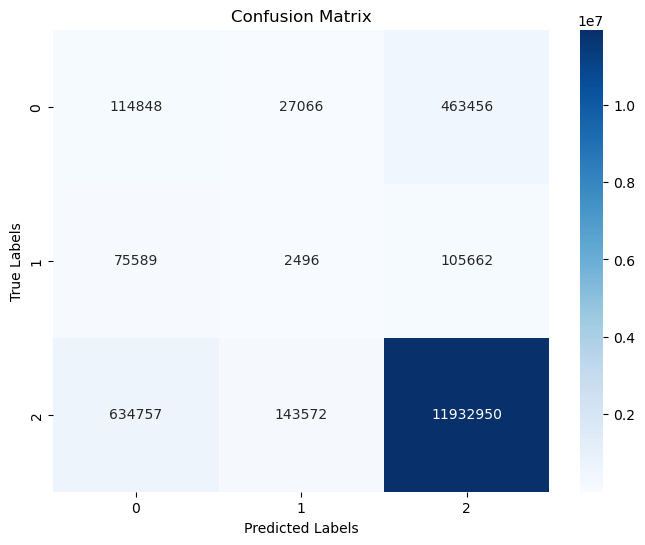

In [13]:
# create a confusion matrix
cm = confusion_matrix(Train_y_test, train_y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_des_tree.classes_,
            yticklabels=train_des_tree.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# make predictions on the test data
test_y_pred = test_des_tree.predict(Test_X_test)

# calculate F1 score 
test_f1 = f1_score(Test_y_test, test_y_pred, average='weighted')
print(f"Test dataset F1 Score: {test_f1:.2f}")

Test dataset F1 Score: 0.90


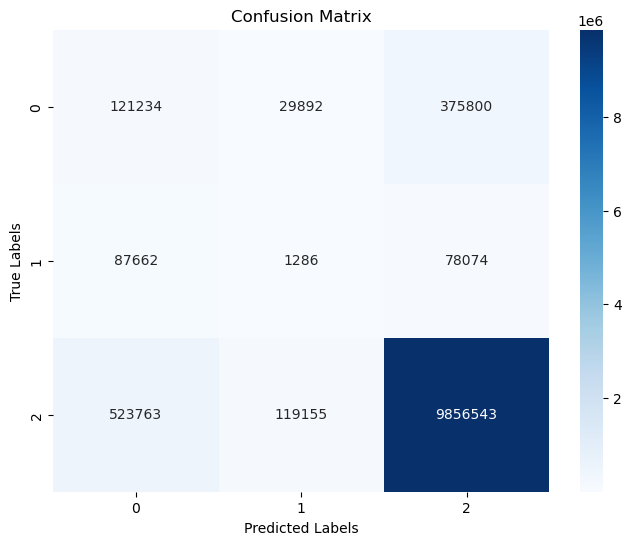

In [15]:
# create a confusion matrix
cm = confusion_matrix(Test_y_test, test_y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_des_tree.classes_,
            yticklabels=test_des_tree.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

TODO: add here the comparison between Decision Tree F1 (0.9) and DLM () and the conclusion

### Model Robustness


In [ ]:
# TODO: import and transform a dataset for verifying the model


## Conclusion